<a href="https://colab.research.google.com/github/TayJen/PyTorch-Practice/blob/main/Detecting_COVID_19_with_Chest_X_Ray_for_Mobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/data_drive/PyTorch_Covid_Mobile
!pwd

/content/drive/Shareddrives/data_drive/PyTorch_Covid_Mobile
/content/drive/Shareddrives/data_drive/PyTorch_Covid_Mobile


In [ ]:
!unzip ./data/archive.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/No

# Importing Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(59)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.12.1+cu113


# Preparing Training and Test Sets

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = './COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

In [ ]:
for c in class_names:
    images = [x for x in os.listdir(os.path.join(root_dir, c, 'images')) if x.lower().endswith('png')]
    selected_images = random.sample(images, 30)
    for image in selected_images:
        print(image)
        source_path = os.path.join(root_dir, c, 'images', image)
        target_path = os.path.join(root_dir, 'test', c, image)
        shutil.move(source_path, target_path)

Normal-5732.png
Normal-7155.png
Normal-1374.png
Normal-3830.png
Normal-10015.png
Normal-7803.png
Normal-10118.png
Normal-6175.png
Normal-8162.png
Normal-7873.png
Normal-4525.png
Normal-6176.png
Normal-3296.png
Normal-8192.png
Normal-224.png
Normal-2274.png
Normal-247.png
Normal-5610.png
Normal-2261.png
Normal-3280.png
Normal-73.png
Normal-6559.png
Normal-7703.png
Normal-3540.png
Normal-5170.png
Normal-8339.png
Normal-2873.png
Normal-75.png
Normal-9090.png
Normal-641.png
Viral Pneumonia-490.png
Viral Pneumonia-611.png
Viral Pneumonia-12.png
Viral Pneumonia-810.png
Viral Pneumonia-992.png
Viral Pneumonia-64.png
Viral Pneumonia-857.png
Viral Pneumonia-532.png
Viral Pneumonia-581.png
Viral Pneumonia-225.png
Viral Pneumonia-794.png
Viral Pneumonia-645.png
Viral Pneumonia-1102.png
Viral Pneumonia-230.png
Viral Pneumonia-473.png
Viral Pneumonia-843.png
Viral Pneumonia-1328.png
Viral Pneumonia-1042.png
Viral Pneumonia-981.png
Viral Pneumonia-916.png
Viral Pneumonia-995.png
Viral Pneumonia-131.

# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': './COVID-19_Radiography_Dataset/normal/images',
    'viral': './COVID-19_Radiography_Dataset/viral/images',
    'covid': './COVID-19_Radiography_Dataset/covid/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [ ]:
test_dirs = {
    'normal': './COVID-19_Radiography_Dataset/test/normal',
    'viral': './COVID-19_Radiography_Dataset/test/viral',
    'covid': './COVID-19_Radiography_Dataset/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                     shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 2511
Num of test batches 15


# Data Visualization

In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

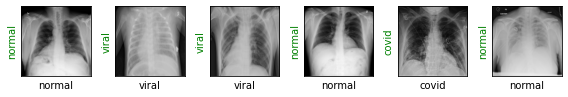

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

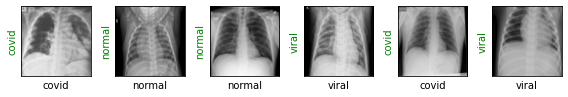

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

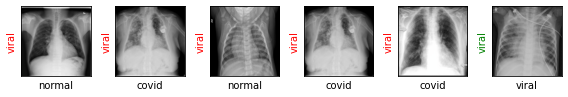

In [ ]:
show_preds()

# Training the Model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0.
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.97:
                    print('Performance condition satisfied..')
                    return
        train_loss /= (train_step + 1)
        print(f'Train loss: {train_loss:.4f}')

Starting training..
Starting epoch 1/3
Evaluating at step 0
Val loss: 1.6040, Acc: 0.35555555555555557


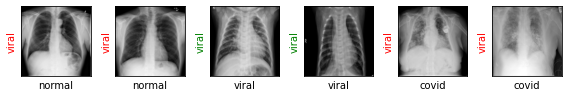

Evaluating at step 20
Val loss: 0.8844, Acc: 0.6111111111111112


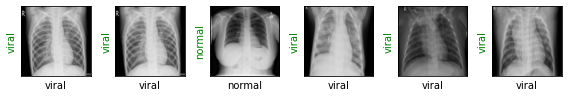

Evaluating at step 40
Val loss: 0.6057, Acc: 0.7


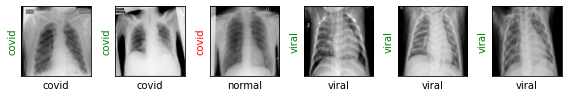

Evaluating at step 60
Val loss: 0.3474, Acc: 0.8666666666666667


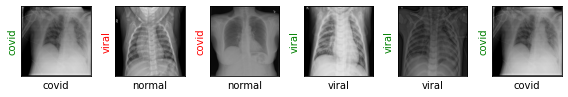

Evaluating at step 80
Val loss: 0.3367, Acc: 0.8666666666666667


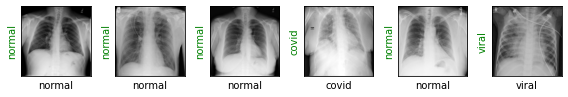

Evaluating at step 100
Val loss: 0.3037, Acc: 0.9


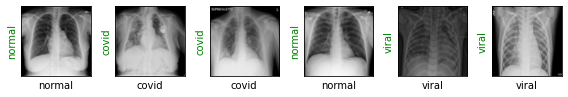

Evaluating at step 120
Val loss: 0.2534, Acc: 0.9555555555555556


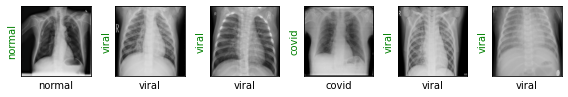

Evaluating at step 140
Val loss: 0.2365, Acc: 0.9333333333333333


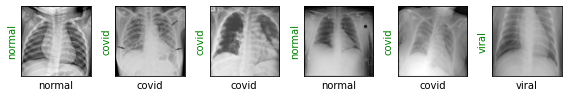

Evaluating at step 160
Val loss: 0.2338, Acc: 0.9111111111111111


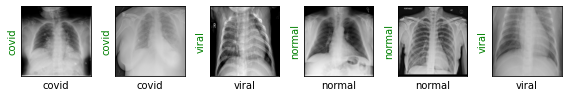

Evaluating at step 180
Val loss: 0.2511, Acc: 0.8888888888888888


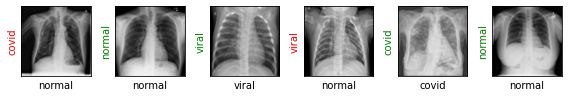

Evaluating at step 200
Val loss: 0.1890, Acc: 0.9444444444444444


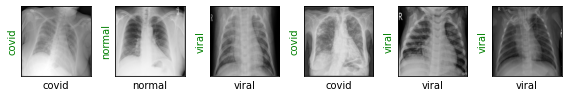

Evaluating at step 220
Val loss: 0.1917, Acc: 0.9111111111111111


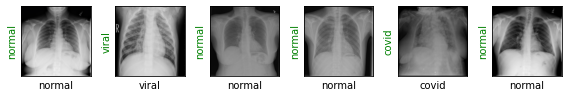

Evaluating at step 240
Val loss: 0.0921, Acc: 0.9888888888888889


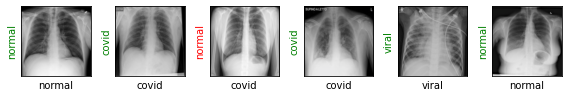

Performance condition satisfied..


In [ ]:
train(3)

# Final Results

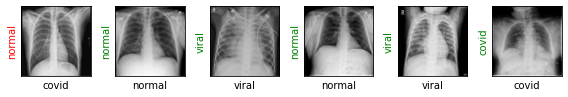

In [ ]:
show_preds()

In [ ]:
resnet18.eval()
images, labels = next(iter(dl_test))
outputs = resnet18(images)
outputs

tensor([[-4.1956,  7.5135, -0.4851],
        [-1.5088, -2.4282,  4.3744],
        [-4.0155,  4.9575,  0.0160],
        [-1.7376,  0.9622,  0.4134],
        [ 0.7098,  1.7571, -2.0404],
        [-0.3133,  1.9987, -1.3243]], grad_fn=<AddmmBackward0>)

In [ ]:
print(f'{torch.nn.Softmax(dim=0)(outputs[0]).detach().numpy()}')

[8.2159322e-06 9.9965596e-01 3.3583338e-04]


# Convert model to mobile, with metadata

In [ ]:
torch.__version__

'1.12.1+cu113'

In [ ]:
images[0].shape

torch.Size([3, 224, 224])

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile

resnet18.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(resnet18, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("resnet18.ptl")